#The Battleship (Group 5)
**Digital Skola Data Science Batch 29 Final Project**

**Water Quality and Potability Prediction**

In this project, we aim to predict the water potability based on a set of features. To train our machine learning model, we will use Scikit Learn and deploy to Streamlit

The dataset is obtained from https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability/data

#1. Import Libraries

In [ ]:
# Step 1: Import relevant libraries---------------------------------------------------------

#Standard libraries for data analysis:----------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math


# sklearn modules for data preprocessing-------------------------------------
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


#sklearn modules for Model Selection--------------------------------------
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


#sklearn modules for Model Evaluation & Improvement---------------------------
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from yellowbrick.classifier import ROCAUC



# from sklearn import feature_selection
from sklearn import model_selection

# from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score


#Standard libraries for data visualization---------------------
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
import plotly.express as px
%matplotlib inline
color = sns.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve

#Miscellaneous Utilitiy Libraries--------------------------------------
import random
import os
import re
import sys
import timeit
import string
from datetime import datetime

#Libaries for Randomforest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split

#libraries for Decission Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Import data from github
df = pd.read_csv('https://raw.githubusercontent.com/rene-gith/water-potability/main/water_potability.csv')

In [ ]:
df

**Attributes Information** <br>
pH: The pH level of the water. <br>
Hardness: Water hardness, a measure of mineral content. <br>
Solids: Total dissolved solids in the water. <br>
Chloramines: Chloramines concentration in the water. <br>
Sulfate: Sulfate concentration in the water. <br>
Conductivity: Electrical conductivity of the water. <br>
Organic_carbon: Organic carbon content in the water. <br>
Trihalomethanes: Trihalomethanes concentration in the water. <br>
Turbidity: Turbidity level, a measure of water clarity. <br>
Potability: Target variable; indicates water potability with values 1 (potable) and 0 (not potable). <br>

In [ ]:
df.info()

All data types are Continuous except Potability is Nominal

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

In [ ]:
# Check target feature

plt.figure(figsize=(5,5))
plt.title('Overall Potability Rate', fontsize=15)
sns.countplot(data=df, x=df['Potability'], color='skyblue', edgecolor='black')

plt.show()

Data is imbalance. We will later use SimpleImputer to balance out

# Exploratory Data Analysis

In [ ]:
# Check distribution of each feature with Hist Plot

plt.figure(figsize=(16, 9))
plt.subplots_adjust(wspace=0.3, hspace=0.4)


# Loop through each column in the dataset
o = 1
for i, col in enumerate(df.columns):
    plt.subplot(4, 4, o)
    sns.histplot(data=df, x=col, kde=True, color='skyblue', edgecolor='black', bins=20)
    plt.title(f'Distribution of {col}')
    o += 1

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Check distribution of each feature with Box Plot

plt.figure(figsize=(16, 9))
plt.subplots_adjust(wspace=0.3, hspace=0.4)


# Loop through each column in the dataset
o = 1
for i, col in enumerate(df.columns):
    plt.subplot(3, 4, o)
    sns.boxplot(data=df, x=col, color='skyblue')
    plt.title(f'Distribution of {col}')
    o += 1

# Display the plots
plt.tight_layout()
plt.show()

Generally speaking, all features are normally distributed except for Solids.

In [ ]:
# Check correlation of each features
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), cbar=True, square= False, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='Blues')
plt.title("Correlation Matrix Heatmap", fontdict={'size': 20})
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.show()

All features seems to have low correlation with Potability.
We will explore with Non-Linear model

# Feature Engineering

In [ ]:
# Based on the histplot, we can conclude that Solids feature needs to be engineered to be normally distributed
plt.figure(figsize=(5,5))

sns.boxplot(data=df,x='Solids',palette="Blues")
plt.title('Solids',fontdict={'size': 20})
plt.xticks(fontsize=12)
plt.xlabel('Solids', fontsize=15)
plt.show()

In [ ]:
# Outliers cleaning function

def outlier_analysis_df(df, col):
    outlier_dict = {}

    # Selected column
    column_data = df[col]

    sorted_data = sorted(column_data)

    # Calculate Q1 and Q3
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)

    # IQR (Interquartile Range)
    iqr = q3 - q1

    # Lower and Upper outlier sınırlarını hesapla
    alt_sinir = q1 - 1.5 * iqr
    ust_sinir = q3 + 1.5 * iqr

    # Find Outliers
    outliers = [x for x in sorted_data if x < alt_sinir or x > ust_sinir]


    df_copy = df.copy()
    df_copy[col] = np.where((df_copy[col] < alt_sinir) | (df_copy[col] > ust_sinir), (q1 + q3) / 2, df_copy[col])

    outlier_dict[col] = outliers

    return df_copy, outlier_dict

In [ ]:
df_without_outliers, outliers_dict = outlier_analysis_df(df, 'Solids')

In [ ]:
# Based on the histplot, we can conclude that Solids feature needs to be engineered to be normally distributed
plt.figure(figsize=(10,5))
sns.boxplot(data=df_without_outliers,x='Solids',palette="Blues")
plt.title('Solids',fontdict={'size': 20})
plt.xticks(fontsize=12)
plt.xlabel('Solids', fontsize=15)
plt.show()

In [ ]:
# Change df_without_outliers back to df
df = df_without_outliers

In [ ]:
df.isna().sum()

In [ ]:
# Check the NaN of the train set by ploting percent of missing values per column
column_with_nan = df.columns[df.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(round(df[i].isnull().sum()*100/len(df), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 5)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(
    x="Percent_NaN",
    y="Column",
    data=tab,
    edgecolor="black",
    color="skyblue")

p.set_title("Percent of NaN per column of the dataset\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=15)
p.set_ylabel("Features", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
# List NaN Columns
nan_columns = df.columns[df.isna().any()]
nan_columns

In [ ]:
# Check distribution of each NaN feature

plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Loop through each column in the dataset
o = 1
for i, col in enumerate(nan_columns):
    plt.subplot(4, 2, o)
    sns.histplot(data=df, x=col, kde=True, color='skyblue', edgecolor='black', bins=20)
    plt.title(f'Distribution of {col}')
    o += 1

# Display the plots
plt.tight_layout()
plt.show()

ph and Trihalomethanes has normal distribution = we use mean or median

Sulfate has left skew = we use mean

To simplify, all feature will use mean.

# Fill NaN with SimpleImputer Mean

In [ ]:
# Imputation of missing values (NaNs) with SimpleImputer with Mean Strategy
my_imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(my_imputer.fit_transform(df))
df_imputed.head()

In [ ]:
df_imputed.columns = df.columns
df_imputed.head()

In [ ]:
df_imputed.isna().sum()

In [ ]:
# Let's check the distribution of each imputed feature before and after imputation

# Define figure parameters
sns.set(rc={"figure.figsize": (16, 9)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2)

# Plot the results
for feature, fig_pos in zip(['ph', 'Sulfate', 'Trihalomethanes'], [0, 1, 2]):

    """Features distribution before and after imputation"""

    # before imputation
    plt.set_title('Before Imputation')
    p = sns.histplot(ax=axes[fig_pos, 0], x=df[feature],
                     kde=True, bins=30, color="darkorange", edgecolor="black")

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_imputed[feature],
                     kde=True, bins=30, color="skyblue", edgecolor="black")
    q.set_title('After Imputation', fontsize=15)

plt.subplots_adjust(hspace=0.7)
plt.show()

The distribution did not change after imputation, we will use this data

#Handling Data

##Split Dataset Into Predictor and Response Variables

In [ ]:
# Split dataset into dependent and independent variables

#identify predictor and response variable:
response = df_imputed["Potability"]
predictor = df_imputed.drop(columns=["Potability"])

##Generate Training and Test Dataset of Predictor and Response Variables

In [ ]:
# Generate training and test datasets of dependent and independent variables
X_train, X_test, y_train, y_test = train_test_split(predictor, response,
                                                    stratify=response,
                                                    test_size = 0.2,
                                                    random_state = 0)

#to resolve any class imbalance - use stratify parameter
print(" X_train dataset: ", X_train.shape)
print(" y_train dataset: ", y_train.shape)
print(" X_test dataset: ", X_test.shape)
print(" y_test dataset: ", y_test.shape)

 X_train dataset:  (2620, 9)
 y_train dataset:  (2620,)
 X_test dataset:  (656, 9)
 y_test dataset:  (656,)


##Handling Imbalance with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_resampled.shape))
print('After OverSampling, the shape of train_y: {}\n'.format(y_train_resampled.shape))
print("After OverSampling, counts of label '1' y_train_resampled: {}".format(sum(y_train_resampled==1)))
print("After OverSampling, counts of label '0' y_train_resampled: {} \n".format(sum(y_train_resampled==0)))

print("After OverSampling, counts of label '1' y_test: {}".format(sum(y_test==1)))
print("After OverSampling, counts of label '0' y_test: {}".format(sum(y_test==0)))

Before OverSampling, counts of label '1': 1022
Before OverSampling, counts of label '0': 1598 

After OverSampling, the shape of train_X: (3196, 9)
After OverSampling, the shape of train_y: (3196,)

After OverSampling, counts of label '1' y_train_resampled: 1598
After OverSampling, counts of label '0' y_train_resampled: 1598 

After OverSampling, counts of label '1' y_test: 256
After OverSampling, counts of label '0' y_test: 400


##Feature Scaling

In [ ]:
# Feature Scaling

sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train_resampled))
X_train2.columns = X_train_resampled.columns.values
X_train2.index = X_train_resampled.index.values
X_train_resampled = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

# Model

In [ ]:
from sklearn.neural_network import MLPClassifier
#Compare Baseline Classification Algorithms Using Accuracy and ROC AUC Mean Metrics
models = []

models.append(('MLP Classifier', MLPClassifier(hidden_layer_sizes=(50), max_iter=1000, random_state=0)))

models.append(('Support Vector Classifier', SVC(probability=True, random_state=0)))

models.append(('Decision Tree', DecisionTreeClassifier(criterion='entropy', random_state=0)))

models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)))

models.append(('K-Nearest Neighbor', KNeighborsClassifier(n_neighbors=5)))

models.append(('XGBoost', XGBClassifier(random_state=0)))

#Evaluating Model Results:
acc_results = []
auc_results = []
names = []
# set table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD',
       'Accuracy Mean', 'Accuracy STD']

model_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using k-fold cross-validation
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10)  # 10-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(
    model, X_train_resampled, y_train_resampled, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(
    model, X_train_resampled, y_train_resampled, cv=kfold, scoring='roc_auc')


    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1

model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
3,Random Forest,79.03,5.78,71.28,4.88
5,XGBoost,74.64,5.36,67.93,4.60
1,Support Vector Classifier,73.24,3.02,66.93,2.10
0,MLP Classifier,72.76,3.11,65.99,2.47
4,K-Nearest Neighbor,69.24,3.63,64.33,3.14
2,Decision Tree,62.58,4.04,62.58,4.04


In [ ]:
# Save the model results into lists
model_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_Score_list=[]

###Multi-Layer Perceptron Classifier

In [ ]:
# Inisialization MLP
mlp = MLPClassifier(hidden_layer_sizes=(50), max_iter=1000, random_state=0)

# Model training
mlp.fit(X_train_resampled, y_train_resampled)

# Predicting the Test set results
y_pred = mlp.predict(X_test)

#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )

model_results = pd.DataFrame([['MLP', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = model_results.sort_values(["Precision", "Recall"], ascending = False)
print (results)

  Model  Accuracy  Precision   Recall  F1 Score
0   MLP  0.606707    0.49635  0.53125  0.513208


In [ ]:
# Parameters to be tuned
param_grid = {
    'hidden_layer_sizes': [(50,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp2 = MLPClassifier(max_iter=1000)

# Create Grid Search
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=5, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
#save best parameter as best_mlp
best_mlp = grid_search.best_estimator_

# Predicting the test set results using best parameter
y_pred = best_mlp.predict(X_test)

#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )

#Save model performance to model_list
model_list.append(best_mlp.__class__.__name__)
accuracy_list.append(acc)
precision_list.append(prec)
recall_list.append(rec)
f1_Score_list.append(f1)

model_results = []
model_results = pd.DataFrame([['MLP', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results_mlp = model_results.append(model_results, ignore_index=True)
model_results

<ipython-input-98-9d5fb3dfbec2>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_mlp = model_results.append(model_results, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score
0,MLP,0.612805,0.503788,0.519531,0.511538


there is an increase in accuracy from 60.6% to **61.28%**

###Support Vector Classifiers

In [ ]:
# Inisialization MLP
clf_svc = SVC(probability=True, random_state=0)

# Model training
clf_svc.fit(X_train_resampled, y_train_resampled)

# Predicting the Test set results
y_pred = clf_svc.predict(X_test)

#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )

model_results = pd.DataFrame([['MLP', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = model_results.sort_values(["Precision", "Recall"], ascending = False)
print (results)

  Model  Accuracy  Precision   Recall  F1 Score
0   MLP   0.61128   0.501845  0.53125  0.516129


In [ ]:
# Parameters to be tuned
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],  # Relevant only for 'poly' kernel
}

svc1 = SVC()

# Create Grid Search
grid_search1 = GridSearchCV(svc1, param_grid, n_jobs=-1, cv=5, verbose=2)
grid_search1.fit(X_train_resampled, y_train_resampled)
print("Best parameters found: ", grid_search1.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters found:  {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
#save best parameter as best_mlp
best_svc = grid_search1.best_estimator_

# Predicting the test set results using best parameter
y_pred = best_svc.predict(X_test)

#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )

#Save model performance to model_list
model_list.append(best_svc.__class__.__name__)
accuracy_list.append(acc)
precision_list.append(prec)
recall_list.append(rec)
f1_Score_list.append(f1)

model_results = pd.DataFrame([['SVC', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results_svc = model_results.append(model_results, ignore_index=True)
model_results

<ipython-input-101-0eb084510dc4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_svc = model_results.append(model_results, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score
0,SVC,0.625,0.517606,0.574219,0.544444


###Random Forest Classifier

In [ ]:
#Random Forest
# Fitting Random Forest to the Training set:

classifier = RandomForestClassifier(n_estimators=22, criterion='entropy', random_state=0)
classifier.fit(X_train_resampled, y_train_resampled)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Evaluate results
#acc = accuracy_score(y_test, y_pred)
#prec = precision_score(y_test, y_pred)
#rec = recall_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Random Forest', acc, prec, rec, f1]],
               columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results_RF = model_results.append(model_results, ignore_index=True)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.69       400
         1.0       0.50      0.47      0.49       256

    accuracy                           0.61       656
   macro avg       0.59      0.59      0.59       656
weighted avg       0.61      0.61      0.61       656



<ipython-input-102-96166ecf729a>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_RF = model_results.append(model_results, ignore_index=True)


In [ ]:
# Tunning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import randint
from sklearn.metrics import classification_report

# Create a Random Forest model
RF_model = RandomForestClassifier()

# Define hyperparameter search space for Random Forest
RF_param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

# Create cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform hyperparameter tuning with RandomizedSearchCV for Random Forest
RF = RandomizedSearchCV(RF_model, RF_param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
RF.fit(X_train_resampled, y_train_resampled)

# Get the best estimator from RandomizedSearchCV for Random Forest
best_RF = RF.best_estimator_


In [ ]:
# Train the best Random Forest model on the training data
best_RF.fit(X_train_resampled, y_train_resampled)

# Predict on the test data for Random Forest
pred_RF = best_RF.predict(X_test)
pred_prob_RF = best_RF.predict_proba(X_test)

# Evaluate results
acc = accuracy_score(y_test, pred_RF)
prec = precision_score(y_test, pred_RF)
rec = recall_score(y_test, pred_RF)
f1 = f1_score(y_test, pred_RF)

#Save model performance to model_list
model_list.append(best_RF.__class__.__name__)
accuracy_list.append(acc)
precision_list.append(prec)
recall_list.append(rec)
f1_Score_list.append(f1)

# Display classification report for Random Forest
print("Classification Report for Random Forest:")
print(classification_report(y_test, pred_RF))

Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.70       400
         1.0       0.53      0.52      0.52       256

    accuracy                           0.63       656
   macro avg       0.61      0.61      0.61       656
weighted avg       0.63      0.63      0.63       656



### K-Nearest Neighbours Classfier

In [ ]:
# K-Nearest Neighbour to the Training set:

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_resampled, y_train_resampled)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Evaluate results
#acc = accuracy_score(y_test, y_pred)
#prec = precision_score(y_test, y_pred)
#rec = recall_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Random Forest', acc, prec, rec, f1]],
               columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results_KNN = model_results.append(model_results, ignore_index=True)


<ipython-input-105-d2937462e637>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_KNN = model_results.append(model_results, ignore_index=True)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.60      0.65       400
         1.0       0.49      0.59      0.54       256

    accuracy                           0.60       656
   macro avg       0.59      0.60      0.59       656
weighted avg       0.62      0.60      0.60       656



In [ ]:
# K-Nearest Neighbors (KNN) model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import randint
from sklearn.metrics import classification_report

# Create a K-Nearest Neighbors (KNN) model
KNN_model = KNeighborsClassifier()

# Define hyperparameter search space for KNN
KNN_param_dist = {
    "n_neighbors": randint(1, 10),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Create cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform hyperparameter tuning with RandomizedSearchCV for KNN
KNN = RandomizedSearchCV(KNN_model, KNN_param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
KNN.fit(X_train_resampled, y_train_resampled)

# Get the best estimator from RandomizedSearchCV for KNN
best_KNN = KNN.best_estimator_


In [ ]:
# Train the best KNN model on the training data
best_KNN.fit(X_train_resampled, y_train_resampled)

# Predict on the test data for KNN
pred_KNN = best_KNN.predict(X_test)
pred_prob_KNN = best_KNN.predict_proba(X_test)

# Evaluate results
acc = accuracy_score(y_test, pred_KNN)
prec = precision_score(y_test, pred_KNN)
rec = recall_score(y_test, pred_KNN)
f1 = f1_score(y_test, pred_KNN)

#Save model performance to model_list
model_list.append(best_KNN.__class__.__name__)
accuracy_list.append(acc)
precision_list.append(prec)
recall_list.append(rec)
f1_Score_list.append(f1)

# Display classification report for KNN
print("Classification Report for K-Nearest Neighbors:")
print(classification_report(y_test, pred_KNN))

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

         0.0       0.69      0.59      0.63       400
         1.0       0.47      0.58      0.52       256

    accuracy                           0.59       656
   macro avg       0.58      0.58      0.58       656
weighted avg       0.60      0.59      0.59       656



### Decission Tree



In [ ]:
#from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold

# Kemudian, Anda dapat membuat objek RepeatedStratifiedKFold seperti ini:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)



# Create a Decision Tree model
DT_model = DecisionTreeClassifier()

# Define hyperparameter search space
param_dist = {
    "max_depth": [3, None],
    "max_features": randint(1, X_train_resampled.shape[1]),
    "min_samples_leaf": randint(1, X_train_resampled.shape[0]),
    "criterion": ["gini", "entropy"]
}

# Create cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform hyperparameter tuning with RandomizedSearchCV
DT = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
DT.fit(X_train_resampled, y_train_resampled)

# Get the best estimator from RandomizedSearchCV
best_DT = DT.best_estimator_

# Train the best Decision Tree model on the training data
best_DT.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
pred = best_DT.predict(X_test)
pred_prob = best_DT.predict_proba(X_test)

#Evaluate results
acc = accuracy_score(y_test, pred )
prec = precision_score(y_test, pred )
rec = recall_score(y_test, pred )
f1 = f1_score(y_test, pred )

#Save model performance to model_list
model_list.append(best_DT.__class__.__name__)
accuracy_list.append(acc)
precision_list.append(prec)
recall_list.append(rec)
f1_Score_list.append(f1)

# Display classification report
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

         0.0       0.65      0.62      0.63       400
         1.0       0.45      0.48      0.46       256

    accuracy                           0.56       656
   macro avg       0.55      0.55      0.55       656
weighted avg       0.57      0.56      0.57       656



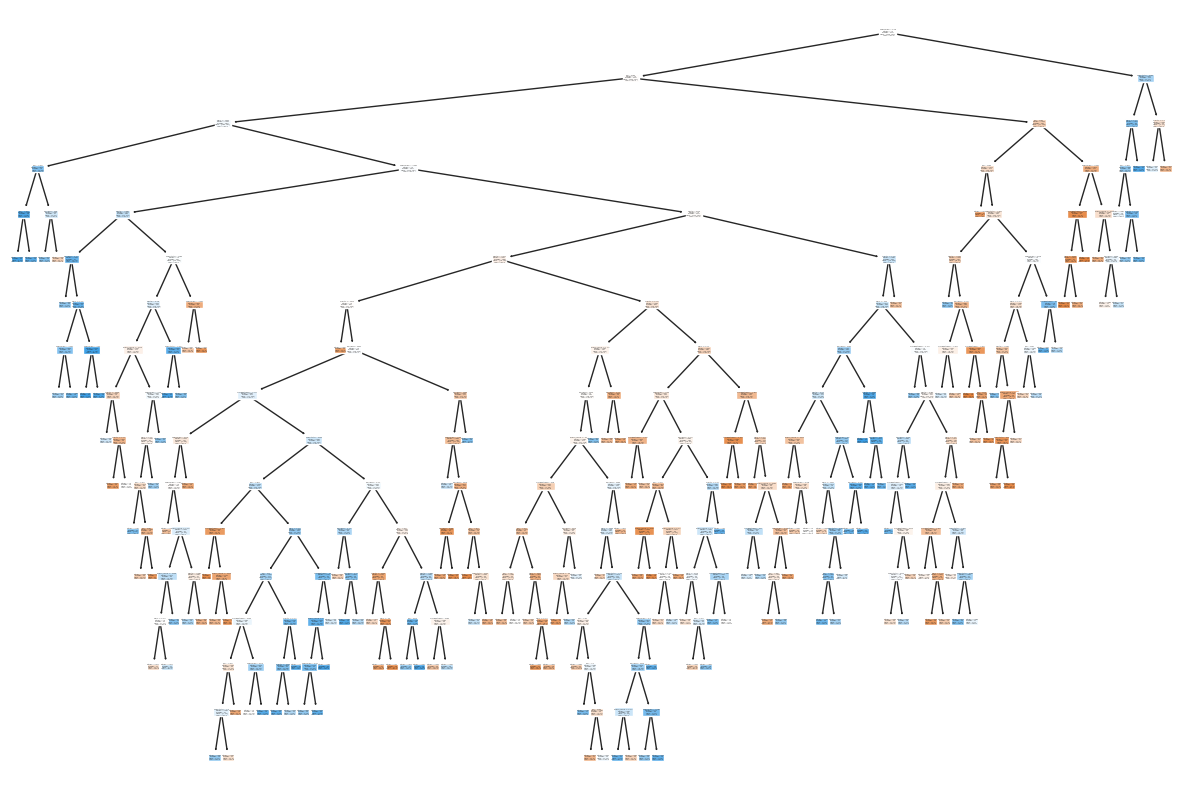

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Replace 'best_DT' with your trained Decision Tree model
trained_DT = best_DT

plt.figure(figsize=(15, 10))
plot_tree(trained_DT, filled=True, feature_names=X_train_resampled.columns, class_names=['Class 0', 'Class 1'])

plt.show()


### XG Boost Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Create an XGBoost model
XGB_model = XGBClassifier()

# Define hyperparameter search space
param_dist = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

# Create cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Perform hyperparameter tuning with RandomizedSearchCV
XGB = RandomizedSearchCV(XGB_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
XGB.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = XGB.predict(X_test)

#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )

# Display classification report and accuracy
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Get the best estimator from RandomizedSearchCV
best_XGB = XGB.best_estimator_

#Save model performance to model_list
model_list.append(best_XGB.__class__.__name__)
accuracy_list.append(acc)
precision_list.append(prec)
recall_list.append(rec)
f1_Score_list.append(f1)

In [ ]:
# Access and plot feature importances
xgbf = pd.DataFrame(best_XGB.feature_importances_, index=X_train_resampled.columns).sort_values(by=0)
plt.figure(figsize=(8, 4))
plt.barh(xgbf.index, xgbf.values[:, 0])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()



# Model Evaluation

## Accuracy VS Model

In [ ]:
data_list = {'Model': model_list,
             'Accuracy': accuracy_list,
             'Precision': precision_list,
             'Recall':recall_list,
             'F1 Score': f1_Score_list}
modeldf = pd.DataFrame(data_list)
modeldf

In [ ]:
line = px.line(data_frame=modeldf, y = ['Accuracy'], markers = True)
line.update_xaxes(title = "Model", rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="skyblue")
line.update_layout(showlegend=True,
                   title = {
                       'text': 'Accuracy vs Model',
                       'y': 0.94,
                       'x': 0.5,
                       'xanchor': 'center',
                       'yanchor': 'top'
                   })
line.show()

In [ ]:
#Let us define functions to summarise the Prediction's scores

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Confusion Analysis

In [ ]:
#Plotting Confusion-Matrix of all the predictive Models

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"

def conf_mat_plot(modeldf):
    plt.figure(figsize=[20,3.5*math.ceil(len(modeldf)*len(labels)/14)])

    for i in range(len(modeldf)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(modeldf)/3),3,i+1)
        pred = modeldf[i].predict(Test_X_std)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(modeldf.index[i])
    plt.tight_layout()
    plt.show()


In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

SyntaxError: ignored

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68       400
         1.0       0.51      0.53      0.52       256

    accuracy                           0.62       656
   macro avg       0.60      0.60      0.60       656
weighted avg       0.62      0.62      0.62       656



In [ ]:
#Comparing all the models Scores

print('\033[1mML Algorithms Comparison'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(modeldf, annot=True, vmin=60, vmax=95, cmap='Blues', fmt='.1f')
plt.show()

                                    ML Algorithms Comparison                                    


NameError: ignored

## ROC (Receiver Operating Characteristic)

In [ ]:
# The highest accuracry is  Random Forest model with value of 64, the Evaluate the model using ROC Graph

classifier.fit(X_train_resampled, y_train_resampled)
probs = classifier.predict_proba(X_test)
probs = probs[:, 1]
classifier_roc_auc = accuracy_score(y_test, y_pred )


rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])



plt.ylabel('True Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")



plt.show()

NameError: ignored

#saving the model for the app

In [ ]:
import pickle
pickle.dump(best_RF, open('model_grad.pkl','wb'))